In [1]:
import zipfile
with zipfile.ZipFile('hw2.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [8]:
im = imageio.imread('grace_hopper.png')

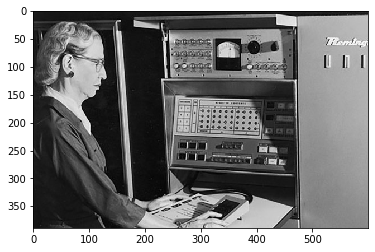

In [6]:
plt.imshow(im, cmap=plt.get_cmap("gray"))
plt.show()

In [3]:
from filters import *
import random

In [5]:
patch = image_patches(im)

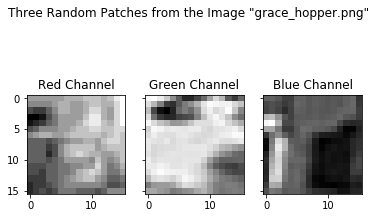

In [13]:
fig, axs = plt.subplots(1, 3)
fig.suptitle('Three Random Patches from the Image "grace_hopper.png"')
axs[0].imshow(patch[random.randrange(0, len(patch), 1)], cmap=plt.get_cmap("gray"))
axs[0].set_title('Red Channel')
axs[1].imshow(patch[random.randrange(0, len(patch), 1)], cmap=plt.get_cmap("gray"))
axs[1].set_title('Green Channel')
axs[2].imshow(patch[random.randrange(0, len(patch), 1)], cmap=plt.get_cmap("gray"))
axs[2].set_title('Blue Channel')
for ax in axs.flat:
    ax.label_outer()
plt.show()

## Gaussian Filter

In [27]:
def convolve(image, kernel):
    # Return the convolution result: image * kernel.
    # Reminder to implement convolution and not cross-correlation!
    # You can use zero- or wrap-padding.
    #
    # Input- image: H x W
    #        kernel: h x w
    #
    # Output- convolve: H x W
    output = np.zeros(image.shape)
    kernel = np.flipud(np.fliplr(kernel))
    width = int(kernel.shape[0]/2)
    height = int(kernel.shape[1]/2)
    if (kernel.shape[0] % 2) == 0 or (kernel.shape[1] % 2) == 0:
        raise ValueError('The kernel is invaild. Please check your input!')
    image_con = np.zeros((image.shape[0]+2*width, image.shape[1]+2*height))
    image_con[width:width+image.shape[0], height:height+image.shape[1]] = image
    print('Compute the center of the image...')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            img = image_con[i:i+2*width+1, j:j+2*width+1]
            output[i,j] = np.sum(img*kernel)

    return output

In [5]:
def gaussian_kernel(size=3, sigma=np.sqrt(1/(2*np.log(2)))):
    """Returns a 2D Gaussian kernel.
    Parameters
    ----------
    size : float, the kernel size (will be square)

    sigma : float, the sigma Gaussian parameter

    Returns
    -------
    out : array, shape = (size, size)
      an array with the centered gaussian kernel
    """
    x = np.linspace(- (size // 2), size // 2, size) 
    x /= np.sqrt(2)*sigma
    x2 = x**2
    kernel = np.exp(- x2[:, None] - x2[None, :])
    return kernel / kernel.sum()

In [28]:
conv = convolve(im, gaussian_kernel())

Compute the center of the image...


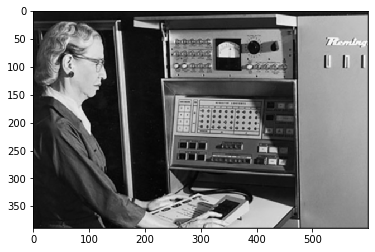

In [29]:
plt.imshow(conv)
plt.gray()
plt.show()

In [69]:
def edge_detection(image):
    # Return the gradient magnitude of the input image
    # Input- image: H x W
    # Output- grad_magnitude: H x W

    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) # 1 x 3
    ky = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) # 3 x 1

    Ix = convolve(image, kx)*0.5
    Iy = convolve(image, ky)*0.5

    grad_magnitude = np.sqrt(Ix**2 + Iy**2)

    return grad_magnitude, Ix, Iy

In [75]:
edge,Ix,Iy = edge_detection(im)

Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...


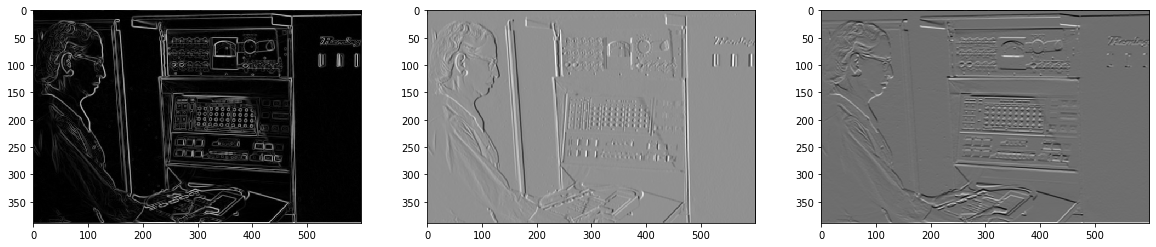

In [84]:
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(edge)
axs[1].imshow(Ix)
axs[2].imshow(Iy)
plt.show()

Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...


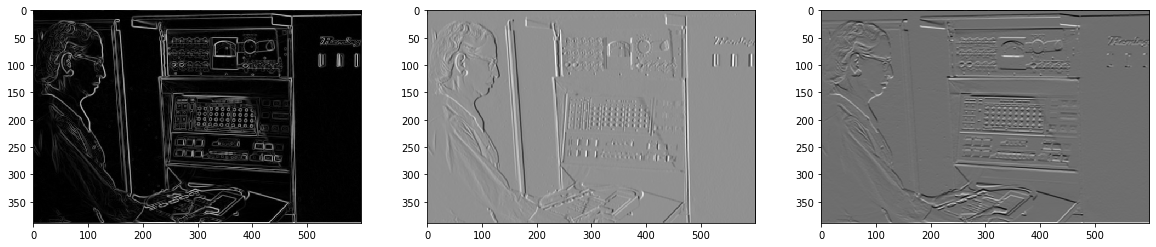

In [83]:
edge,Ix,Iy = edge_detection(conv)
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(edge)
axs[1].imshow(Ix)
axs[2].imshow(Iy)
plt.show()

**Original vs Gaussian blur**:
    - Gaussian blur is more robost to the edges, while the original image has been detected with more noise edges.
    - Gaussian blur has brighter and clearer edges

## Sobel operator

In [5]:
def sobel_operator(image):
    # Return Gx, Gy, and the gradient magnitude.
    # Input- image: H x W
    # Output- Gx, Gy, grad_magnitude: H x W

    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) # 1 x 3
    ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # 3 x 1

    Gx = convolve(image, kx)*0.5
    Gy = convolve(image, ky)*0.5

    grad_magnitude = np.sqrt(Gx**2 + Gy**2)

    return Gx, Gy, grad_magnitude

In [6]:
Gx,Gy,edge = sobel_operator(im)

Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...


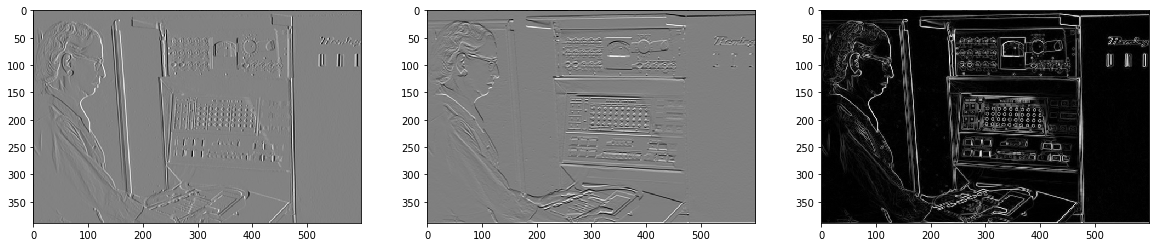

In [9]:
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(edge, cmap=plt.get_cmap("gray"))
axs[1].imshow(Gx, cmap=plt.get_cmap("gray"))
axs[2].imshow(Gy, cmap=plt.get_cmap("gray"))
plt.show()

###  Linear combination of the two Sobel operators (a steerable ﬁlter)

$S(I,α) = G_x cosα + G_y sinα$, and $G_x$ $G_y$ can be written as below:

$ G_x = I *
\begin{bmatrix} 
1 & 0 & -1 \\
2 & 0 & -2\\
1 & 0 & -1 \\
\end{bmatrix}
$

$ G_y = I *
\begin{bmatrix} 
1 & 2 & 1 \\
0 & 0 & 0\\
-1 & -2 & -1 \\
\end{bmatrix}
$

Write the steerable filter function as below:

In [17]:
def steerable_filter(image, angles=(np.pi * np.arange(6, dtype=np.float) / 6)):
    # Given a list of angels used as alpha in the formula,
    # return the corresponding images based on the formula given in pdf.
    # Input- image: H x W
    #        angels: a list of scalars
    # Output- results: a list of images of H x W

    # TODO: Use convolve() to complete the function
    output = [None]*len(angles)
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) # 1 x 3
    ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # 3 x 1
    
    for i in range(len(angles)):
        k = kx * np.cos(angles[i]) + ky * np.sin(angles[i])
        output[i] = convolve(image, k)
    
    return output

In [18]:
out = steerable_filter(im)

Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...
Compute the center of the image...
Compute the edge of the image...


In [20]:
len(out)

6

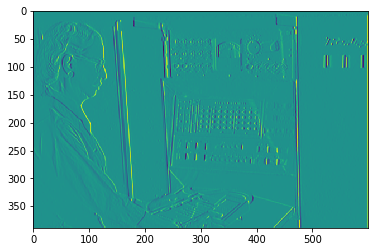

In [21]:
plt.imshow(out[0], cmap=plt.get_cmap('gray'))
plt.show()

## LoG Filter

Compute the center of the image...
Compute the edge of the image...


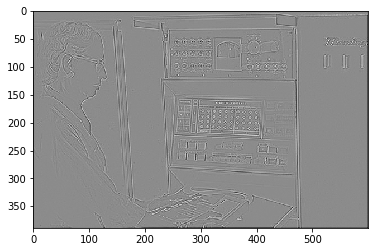

In [27]:
kernel_LoG1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
filtered_LoG1 = convolve(im, kernel_LoG1)
plt.imshow(filtered_LoG1, cmap=plt.get_cmap('gray'))
plt.show()

# Feature Extraction

In [30]:
def corner_score(image, u=5, v=5, window_size=(5, 5)):
    # Given an input image, x_offset, y_offset, and window_size,
    # return the function E(u,v) for window size W
    # corner detector score for that pixel.
    # Input- image: H x W
    #        u: a scalar for x offset
    #        v: a scalar for y offset
    #        window_size: a tuple for window size
    #
    # Output- results: a image of size H x W
    # Use zero-padding to handle window values outside of the image.
    #
    # set up
    width = int(window_size[0]/2)
    height = int(window_size[1]/2)
    diff = 0
    output = np.zeros(image.shape)
    
    # create image_offset containing all info from the image
    image_offset = np.zeros((image.shape[0]+window_size[0]-1, image.shape[1]+window_size[1]-1))
    image_offset[width:width+image.shape[0], height:height+image.shape[1]] = image

    # loop over
    for i in range(image.shape[0]):
        if i%50 == 0:
            print('The',i, 'th iteration...',i,':',image.shape[0])
        for j in range(image.shape[1]):
            for x in range(-width, width+1):
                for y in range(-height, height+1):
                    if i+width+x+u >= image_offset.shape[0] or j+height+y+v >= image_offset.shape[1] or i+width+x+u < 0 or j+height+y+v < 0:
                        pass
                    else:
                        diff += (image_offset[i+width+x+u,j+height+y+v] - image_offset[i+width+x,j+height+y])**2
            output[i,j] = diff
            diff = 0

    return output

In [39]:
# Define offsets and window size and calulcate corner score
u, v, W = 0, 5, (5, 5)
score_up = corner_score(im, u, v, W)
u, v, W = 0, -5, (5, 5)
score_down = corner_score(im, u, v, W)
u, v, W = 5, 0, (5, 5)
score_right = corner_score(im, u, v, W)
u, v, W = -5, 0, (5, 5)
score_left = corner_score(im, u, v, W)

The 0 th iteration... 0 : 389
The 50 th iteration... 50 : 389
The 100 th iteration... 100 : 389
The 150 th iteration... 150 : 389
The 200 th iteration... 200 : 389
The 250 th iteration... 250 : 389
The 300 th iteration... 300 : 389
The 350 th iteration... 350 : 389
The 0 th iteration... 0 : 389
The 50 th iteration... 50 : 389
The 100 th iteration... 100 : 389
The 150 th iteration... 150 : 389
The 200 th iteration... 200 : 389
The 250 th iteration... 250 : 389
The 300 th iteration... 300 : 389
The 350 th iteration... 350 : 389
The 0 th iteration... 0 : 389
The 50 th iteration... 50 : 389
The 100 th iteration... 100 : 389
The 150 th iteration... 150 : 389
The 200 th iteration... 200 : 389
The 250 th iteration... 250 : 389
The 300 th iteration... 300 : 389
The 350 th iteration... 350 : 389
The 0 th iteration... 0 : 389
The 50 th iteration... 50 : 389
The 100 th iteration... 100 : 389
The 150 th iteration... 150 : 389
The 200 th iteration... 200 : 389
The 250 th iteration... 250 : 389
The 

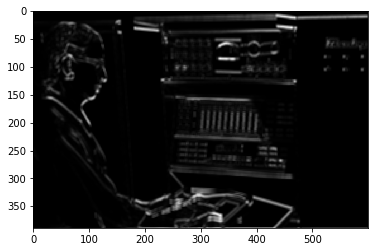

In [43]:
plt.imshow(score_left, cmap=plt.get_cmap('gray'))
plt.show()

## Harris Corner Detector

In [50]:
def harris_detector(image, window_size=(5, 5),alpha = 0.06):
    # Given an input image, calculate the Harris Detector score for all pixels
    # Input- image: H x W
    # Output- results: a image of size H x W
    #
    # You can use same-padding for intensity (or 0-padding for derivatives)
    # to handle window values outside of the image.

    # compute the derivatives
    
    kx = np.array([[-1, 0, 1]]) * 0.5 # 1 x 3
    ky = np.transpose(kx)  # 3 x 1    

    Ix = convolve(image, kx)
    Iy = convolve(image, ky)

    Ixx = Ix*Ix
    Ixy = Ix*Iy
    Iyy = Iy*Iy

#     k_gauss = np.ones(window_size)

    # gaussian kernel works better than the average kernel
    k_gauss = gaussian_kernel(window_size[0],1)
    M = np.zeros((image.shape[0],image.shape[1],3))
    M[:,:,0] = convolve(Ixx,k_gauss)
    M[:,:,1] = convolve(Ixy,k_gauss)
    M[:,:,2] = convolve(Iyy,k_gauss)
    
    R =  M[:,:,0]*M[:,:,2] - M[:,:,1]**2 - alpha*((M[:,:,0]+M[:,:,2]))**2 
    response = R

    return response

In [47]:
R = harris_detector(im)

Compute the center of the image...
Compute the center of the image...
Compute the center of the image...
Compute the center of the image...
Compute the center of the image...


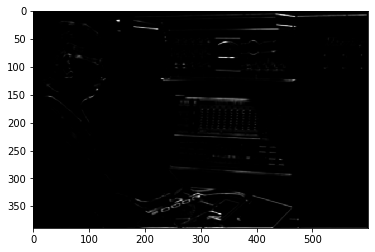

In [49]:
plt.imshow(R, cmap=plt.get_cmap('gray'))
plt.show()

# Blob Detection

## Single-scale Blob Detection - using DoG filter

In [52]:
im = imageio.imread('polka.png')

In [3]:
im.shape

(128, 128)

In [87]:
from filters import *
from scipy import signal
import math
def gaussian_filter(image, sigma):
    # Given an image, apply a Gaussian filter with the input kernel size
    # and standard deviation
    # Input
    #   image: image of size HxW
    #   sigma: scalar standard deviation of Gaussian Kernel
    #
    # Output
    #   Gaussian filtered image of size HxW
    H, W = image.shape
    # -- good heuristic way of setting kernel size
    kernel_size = int(2 * np.ceil(2 * sigma) + 1)

    # Ensure that the kernel size isn't too big and is odd
    kernel_size = min(kernel_size, min(H, W) // 2)
    if kernel_size % 2 == 0:
        kernel_size = kernel_size + 1

    # TODO implement gaussian filtering of size kernel_size x kernel_size
    # You can use your convolution function or scipy's convolution function
#     kernel = np.zeros((kernel_size,kernel_size))
#     for i in range(-int(kernel_size/2),int(kernel_size/2)):
#     	for j in range(-int(kernel_size/2),int(kernel_size/2)):
#     		kernel[j][i] = (1/(2*math.pi*sigma*sigma))*np.exp(-(i**2+j**2)/(2*sigma*sigma))

#     kernel = kernel*1.0
    # kernel = kernel/np.sum(kernel)
    gauss = gaussian_kernel(kernel_size, sigma)
    output = signal.convolve2d(image, gauss, boundary='symm', mode='same')	


    return output 

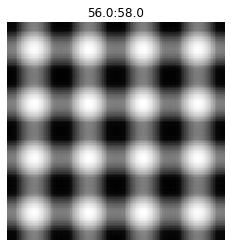

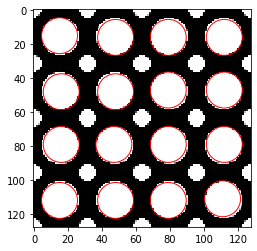

In [89]:
sigma_1, sigma_2 = 56,58
gauss_1 = gaussian_filter(im,sigma_1)
gauss_2 = gaussian_filter(im,sigma_2)

    # calculate difference of gaussians
DoG_large = gauss_2-gauss_1

    # visualize maxima
    # Value of k_xy is a sugguestion; feel free to change it as you wish.
maxima = find_maxima(DoG_large, k_xy=10)
visualize_scale_space(DoG_large, sigma_1, sigma_2 / sigma_1,
                          './polka_detections/polka_large_DoG.png')
visualize_maxima(im, maxima, sigma_1, sigma_2 / sigma_1,
                     './polka_detections/polka_large.png')

In [107]:
def scale_space(image, min_sigma, k=np.sqrt(2), S=8):
    # Calculates a DoG scale space of the image
    # Input
    #   image: image of size HxW
    #   min_sigma: smallest sigma in scale space
    #   k: scalar multiplier for scale space
    #   S: number of scales considers
    #
    # Output
    #   Scale Space of size HxWx(S-1)
    output = np.zeros((image.shape[0], image.shape[1], S-1))
    for i in range(S-1):
        guass_1 = gaussian_filter(image, min_sigma*(k**i))
        guass_2 = gaussian_filter(image, min_sigma*(k**(i+1)))
        output[:,:,i] = guass_2 - guass_1

    return output


In [82]:
scale = scale_space(im, 10)

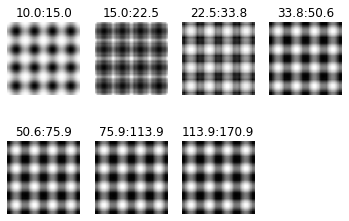

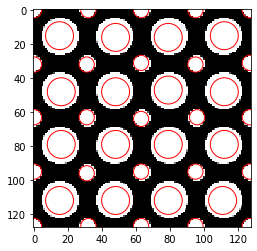

In [108]:
min_sigma = 10
spaces=scale_space(im,min_sigma)
maxima = find_maxima(spaces, k_xy=18)
visualize_scale_space(spaces, min_sig, k, 'polka_scale_space.png')
visualize_maxima(im, maxima, min_sig, k, 'polka_small2large.png')

In [102]:
print(len(maxima))

41


This image has 41 blobs which you can tell easily.

We can evaluate the result using another image from the Visual Geometry Group at Oxford University.

In [137]:
im = imageio.imread('cells/001cell.png', as_gray = True)

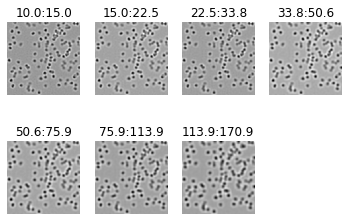

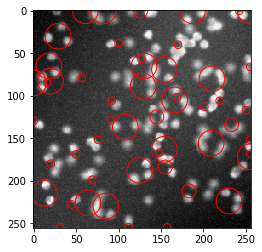

In [130]:
min_sigma = 2.5
spaces=scale_space(im,min_sigma,k=1.1, S = 8)
maxima = find_maxima(spaces, k_xy=15, k_s = 5)
visualize_scale_space(spaces, min_sig, k, 'polka_scale_space.png')
visualize_maxima(im, maxima, min_sig, k, 'polka_small2large.png')

The blob detecter can find some blobs but the overall size is too large, that means the value of S is too large.

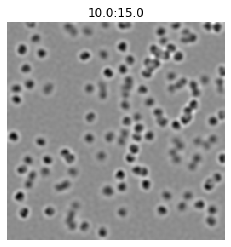

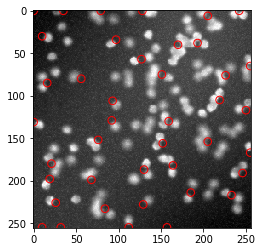

In [136]:
min_sigma = 2
spaces=scale_space(im,min_sigma, S = 2)
maxima = find_maxima(spaces, k_xy=17, k_s = 5)
visualize_scale_space(spaces, min_sig, k, 'polka_scale_space.png')


The final detection of blobs has `41` blobs.